# Introduction
This is the boosted trees learner associated with Voter Analysis.
Please be sure to run DataCleaning.ipynb first to prepare the data

## Imports
Import libraries and write settings here.

In [2]:
from fastai.tabular import *
from fastai import *

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')



# Load train/test and catagorical and continuous column names
If either of the following fail then please be sure to run DataCleaning.ipynb first to prepare the data

In [3]:
trn = pd.read_feather('tmp/train')
tst = pd.read_feather('tmp/tst')

In [4]:
with open('tmp/catcont.json') as f:
    data1 = json.load(f)

    res_cont = data1[0]
    res_cat = data1[1] 
    columns_dep_var = data1[2][0]
    
# res_cont
# res_cat

In [5]:
#remove the dependant variable
res_cont = [x for x in res_cont if x not in columns_dep_var]
res_cat = [x for x in res_cat if x not in columns_dep_var]

In [6]:
#convert trumpgevote to long (otherwise fit fails)
trn[columns_dep_var] = trn[columns_dep_var].astype('int64');
tst[columns_dep_var] = tst[columns_dep_var].astype('int64');

print(str(len(trn)))
print(str(len(tst)))

36801
4089


## Categorify and Fill Missing

In [7]:
#from docs https://docs.fast.ai/tabular.transform.html
tfm = Categorify(cat_names=res_cat, cont_names=res_cont)
tfm(trn)
tfm(tst)

In [8]:
#just checking to see if it works on any old variable
trn[res_cat[0]].cat.categories
tst[res_cat[0]].cat.categories

Int64Index([0, 1], dtype='int64')

Int64Index([0, 1], dtype='int64')

In [9]:
tfm1 = FillMissing(cat_names=res_cat, cont_names=res_cont)
tfm1(trn)
tfm1(tst)

## Clean up any missing columns that result from unfortunate test selection

In [10]:
trn_y=trn[columns_dep_var].copy()
trn=trn.drop(columns_dep_var,axis=1)

tst_y=tst[columns_dep_var].copy()
tst=tst.drop(columns_dep_var,axis=1)

# trn.T
# trn_y

In [11]:
#You cannot have any Nan (missing data) fields or random forest will not work.
print(f"Total trn columns = {len(trn.columns)}, total tst columns = {len(tst.columns)}") 
print(f"Total trn columns with Nans= {len(trn.columns[trn.isnull().any()])}") #add ~ to get columns with no missing values
print(f"Total tst columns with Nans= {len(tst.columns[tst.isnull().any()])}") #add ~ to get columns with no missing values

Total trn columns = 53, total tst columns = 53
Total trn columns with Nans= 0
Total tst columns with Nans= 0


In [12]:
#hmmm if either has 1 more column than train then see what it is
set(tst.columns)-set(trn.columns)
set(trn.columns)-set(tst.columns)

set()

set()

In [13]:
#missing one of the _na columns.  This is added, and set to 1, when a variable has an NaN value to mark
#columns that have NaNs

In [14]:
#find the index of the column in trn
idx=trn.columns.tolist().index('cc.catholic_na')
idx
type(trn.columns)

41

pandas.core.indexes.base.Index

In [15]:
# tst.insert(loc=idx, column='cc.catholic_na', value=False)

# BoostedTrees - LightGBM

In [16]:
import lightgbm
# Create the LightGBM data containers
#
# categorical_features = [c for c, col in enumerate(train.columns) if 'cat' in col]  # none its one hotted
train_data = lightgbm.Dataset(trn, label=trn_y)
test_data = lightgbm.Dataset(tst, label=tst_y)

In [17]:
#use the defaults
model_lgbm1 = lightgbm.LGBMClassifier(objective='binary')
#set objective='regression' for linear regression

In [18]:
#train the model
model_lgbm1.fit(trn, trn_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

## Try SHAP importance

In [19]:
import shap

In [20]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model_lgbm1)
shap_values = explainer.shap_values(trn)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], trn.iloc[0,:])

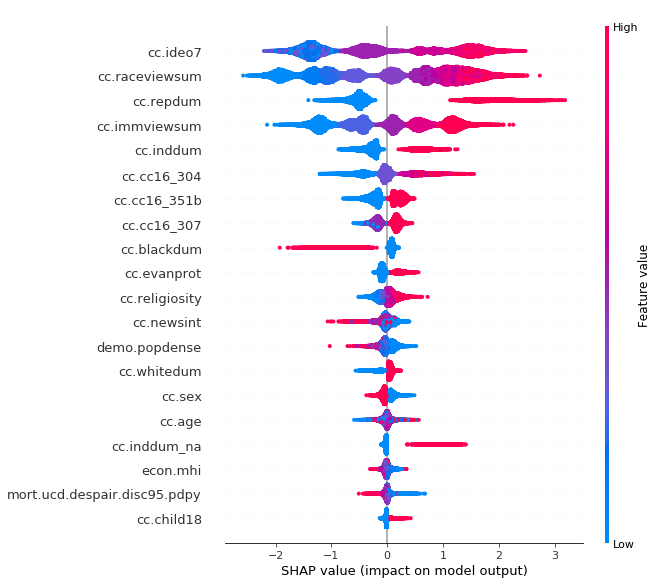

In [21]:
# visualize the training set predictions
shap.summary_plot(shap_values, trn)

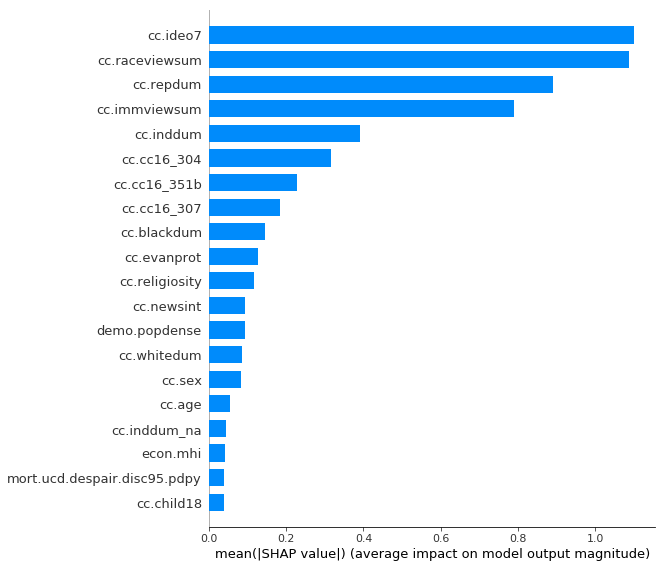

In [23]:
shap.summary_plot(shap_values, trn, plot_type="bar")

In [35]:
trn.sample(n=3)

,cc.blackdum,econ.mhi,cc.sex,cc.maxeduc.4yr,econ.hhpov.p,mort.ucd.despair.disc95.pdpy,cc.union,cc.age,demo.popdense,cc.emp.nojob,rustpc,taa.wrks.disc95.pcpy,cc.faminc,crashpc,cc.newsint,cc.isimmigrant,cc.catholic,cc.cc16_305_2,job.uer,cc.child18,cc.evanprot,cc.whitedum,cc.religiosity,cc.cc16_351b,cc.cc16_307,cc.immviewsum,cc.cc16_304,cc.inddum,cc.ideo7,cc.raceviewsum,cc.repdum,econ.mhi_na,econ.hhpov.p_na,mort.ucd.despair.disc95.pdpy_na,cc.union_na,demo.popdense_na,rustpc_na,taa.wrks.disc95.pcpy_na,cc.faminc_na,crashpc_na,cc.newsint_na,cc.catholic_na,job.uer_na,cc.child18_na,cc.evanprot_na,cc.religiosity_na,cc.cc16_351b_na,cc.cc16_307_na,cc.cc16_304_na,cc.inddum_na,cc.ideo7_na,cc.raceviewsum_na,cc.repdum_na
33703,0,78.790000,1,1,4.083333,0.033737,0.0,79,563.108476,0,0.042955,0.000369,4.0,0.128733,1.0,0,0.0,0,8.500000,0.0,0.0,1,4.0,1.0,3.0,0.00,2.0,0.0,1.0,1.50,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
17102,0,57.941167,1,0,8.666667,0.095172,0.0,63,300.491975,0,0.057972,0.000413,5.0,0.119329,2.0,0,1.0,0,8.666667,0.0,1.0,1,14.0,0.0,4.0,0.00,3.0,0.0,4.0,2.00,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
31792,1,27.515667,1,0,29.633333,0.029896,1.0,50,30.389151,0,0.084285,0.000155,3.0,0.252694,2.0,0,0.0,0,19.800000,1.0,1.0,0,15.0,1.0,3.0,0.75,2.0,0.0,4.0,2.25,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# Test the model on test data

In [ ]:
def eval_accuracy(preds,targs):
    totals = len(preds)
    matches = 0
    for x in zip(preds,targs):
        if x[0]==x[1]:
            matches+=1
    print(f"Got {matches} right out of {totals} samples, Accuracy is {100*matches/totals} percent")

In [ ]:
#make predictions
preds1 = model_lgbm1.predict(tst)

In [ ]:
eval_accuracy(preds1,tst_y)

# Results
Show graphs and stats here

# Conclusions and Next Steps
This model is 92.36% accurate with no data tweaks

# Scratch

In [ ]:
data = test[0]
data[31]
type(data)
data.shape
tmp=learn.predict(data)
len(tmp)
out,pred,res=tmp

out
pred
res

# len(out)
# len(pred)
len(res)